# Absorption Spectra

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as stats
from scipy import optimize
import pandas as pd
import glob
import re

In [339]:
def read_TDDFT_file(file_name):    
    output_file = list(open(file_name))
                
    energy = None
    tdm = None
    is_here = True
    
    excited_state_lines = []

    for enum, line in enumerate(output_file):
        if "Excited State" in line or "Transition Dipole Moments (a.u.)" in line or "Oscillator Strengths (a.u.):" in line:
            excited_state_lines.append(enum)

    if(len(excited_state_lines) == 0):
        return (False, None, None)
            
    homo_lumo_state = 0
    homo_lumo_coeff = 0
    homo_lumo_state_line = None
    homo_lumo_dipole_line = None

    for i in range(len(excited_state_lines)-2):
        for line in output_file[excited_state_lines[i]:excited_state_lines[i+1]]:
            if "->" in line:
                MOs = re.findall(r'\d+', line)
                if abs(int(MOs[1]) - int(MOs[0])) != 1:
                    continue
                coeff = re.findall(r'-?\d+\.\d+', line)[0]
                if abs(float(coeff)) > homo_lumo_coeff:
                    homo_lumo_state = i+1
                    homo_lumo_coeff = float(coeff)
                    homo_lumo_state_line = output_file[excited_state_lines[i]]

    for line in output_file[excited_state_lines[-2]:excited_state_lines[-1]]:
        if re.match(fr' {homo_lumo_state}', line):
            homo_lumo_dipole_line = line

    nums = re.findall(r'\d+\.\d+', homo_lumo_state_line)
    energy= float(nums[1])
    tdm = np.array([float(x) for x in re.findall(r'-?\d+\.\d+', homo_lumo_dipole_line)])

        
    is_here = all([energy is not None, tdm is not None])
    
    if not is_here:
        print(file_name)
        return(is_here, None, None)
    else:
        return(is_here, energy, tdm)
    
def read_excited_scf_file(file_name):
    
    output_file = list(open(file_name))
    
    energy = None
    tdm = None
    is_here = True
    
    for line in output_file:
        if "Excitation energy (in eV):" in line:
            energy = float(re.findall(r'\d+\.\d+', line)[0])

        if "Transition dipole" in line:
            tdm = np.array([float(x) for x in re.findall(r'-?\d+\.\d+', line)])

    is_here = all([energy is not None, tdm is not None])
    
    if not is_here:
        return(is_here, None, None)
    else:
        return(is_here, energy, tdm)

    
def read_method(method):
    dipole_mags = []
    frames = []
    energies = []
    dipoles = []
    
    for i in glob.glob(f"{method}/*out"):    
        file_is_here, energy, dipole = (None,) * 3

        if method in ["PBE0", "CAMB3LYP", "BLYP"]:
            file_is_here, energy, dipole = read_TDDFT_file(i)
        else:
            file_is_here, energy, dipole = read_excited_scf_file(i)

        if file_is_here:
            frames.append(int(re.findall(r'\d+', i)[-1]))
            energies.append(energy)
            dipoles.append(dipole)
            dipole_mags.append(np.linalg.norm(dipole))

    data = np.array(energies)
    mu, std = norm.fit(data)
    
    z_value = lambda x : (x - mu)/std
            
    result = pd.DataFrame({
        'frames' : frames,
        'excitation energy' : energies,
        'dipole magnitude' : dipole_mags,
        'dipole' : dipoles,
        'z value' : [z_value(x) for x in energies]
    })
    
    #result = result.drop(result[abs(result["z value"]) > 1.5].index)
    
    result = result.sort_values('frames')
    result = result.set_index('frames')
    
    return result

In [340]:
bchla = read_method("bchla")

In [341]:
PBE0 = read_method("PBE0")

In [342]:
CAMB3LYP = read_method("CAMB3LYP")

In [343]:
BLYP = read_method("BLYP")

In [344]:
eigdiff = read_method("eigdiff")

In [345]:
dscf = read_method("dscf")

In [373]:
bchla_gfn1 = read_method("bchla_gfn1")

In [359]:
def gaussian(x, height, center, width):
    return height*np.exp(-(x - center)**2/(2*width**2))
    
def hist_and_curve(ax, method, name, maxima=703, align=False):
    line_map = {"PBE0" : 'solid', 
              "CAMB3LYP" : 'dashed',
              "BLYP" : 'dotted',
              "eigdiff" : 'dashdot',
              "dscf" : (0, (1, 10)),
              "bchla" : "solid",
              "bchla_gfn1" : "solid"
             }
    
    energies_eV = method["excitation energy"].to_numpy()

    eV_to_nm = lambda x : (4.136e-15 * 3e17) / x # (h eV s) * (c nm s^-1) / (E eV) 

    energies_nm = eV_to_nm(energies_eV)
    
    density = stats.gaussian_kde(energies_nm)    
    
    x = np.linspace(300, 700, 1000)
    if align:
        this_maxima = np.argmax(density(x))
        diff = x[this_maxima] - x[maxima]

        if name == "bchla":
            ax.plot(x, density(x), linestyle = line_map[name], color='red', label=name)

            return this_maxima, x[this_maxima]
        
        elif name == "bchla_gfn1":
            ax.plot(x, density(x+diff), linestyle = line_map[name], color='maroon', label=name)

        else:
            ax.plot(x, density(x + diff), linestyle = line_map[name], color='black', label=name)
    else:
        if name == "bchla":
            ax.plot(x, density(x), linestyle = line_map[name], color='red', label=name)
            return _, _

        elif name == "bchla_gfn1":
            ax.plot(x, density(x), linestyle = line_map[name], color='maroon', label=name)
            

        else:
            ax.plot(x, density(x), linestyle = line_map[name], color='black', label=name)
            

In [376]:
from scipy.integrate import simps

def plot_experimental(ax, maxima, align=False):
    data = np.loadtxt("experimental_data.txt", skiprows=1)
    data = data[data[:,0] > 500]        

    data = data[data[:, 0].argsort()]
        
    x=data[:,0]
    y=data[:,1]
    area = simps(y, x)

    if align:
        this_maxima = np.argmax(data[:,1])
        diff = data[:,0][this_maxima] - maxima
    
        ax.plot(x-diff, y/area, label="experimental")
    else:
        ax.plot(x, y/area, label="experimental")
    
#plot_experimental(0,0,0)

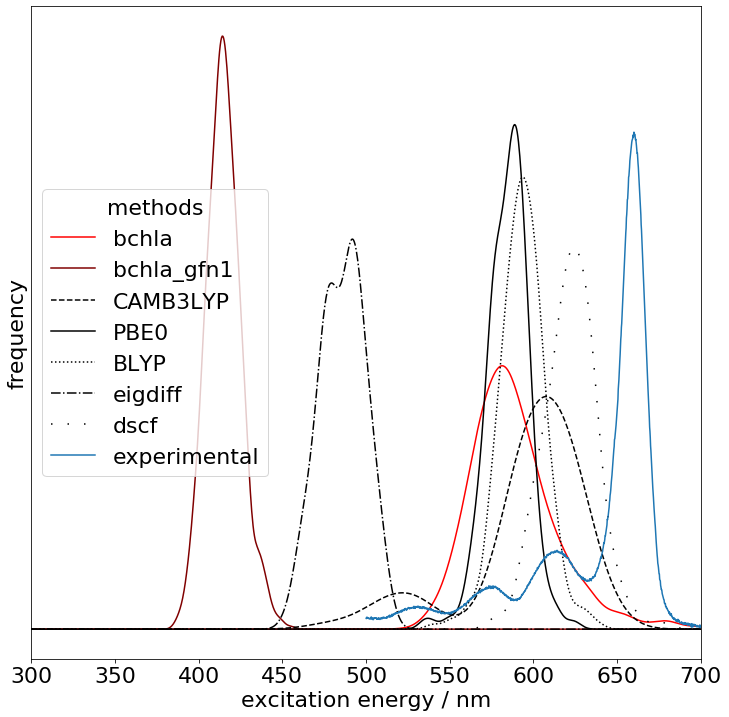

In [378]:
#fig, ax = plt.subplots(4, 1)
#ax1, ax2, ax3, ax4 = ax.ravel()
align = False

fig, ax = plt.subplots()
maxima, freq_maxima = hist_and_curve(ax, bchla, "bchla", align=align)
hist_and_curve(ax, bchla_gfn1, "bchla_gfn1", align=align)
hist_and_curve(ax, CAMB3LYP, "CAMB3LYP", maxima, align)
hist_and_curve(ax, PBE0, "PBE0", maxima, align)
hist_and_curve(ax, BLYP, "BLYP", maxima, align)
hist_and_curve(ax, eigdiff, "eigdiff", maxima, align)
hist_and_curve(ax, dscf, "dscf", maxima, align)
plot_experimental(ax, freq_maxima, align)
fig.set_size_inches(12,12)
ax.legend(title="methods")
ax.set_xlabel("excitation energy / nm")
ax.set_ylabel("frequency")
ax.set_xlim(300, 700)
plt.yticks([])
plt.rcParams.update({'font.size': 22})
plt.show()